<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/breastcancer_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo with Wisconsin Breast cancer data set
Data source is [here](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)).

In [ ]:
# Last amended: 5th June, 2023

## Basics

In [1]:
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.6/228.6 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 53.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 45.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 64.3 MB/s eta 0:00:00
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395106 sha256=0dcffdd7624ecf5a86703a6a9ca3df3bd2edaac3b8b24aa8d2248eb251a13106
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df6

In [2]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns


# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'karateclub', 'graph_tool', 'wurlitzer', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'infomap'}


In [3]:
# 1.05 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [4]:
# 2.0 Read Data
data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/breastcancer.csv")
data.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [5]:
# 2.1
data.shape   # (569, 30)
print("\n==dtypes====\n")
data.dtypes

(569, 33)


==dtypes====



id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [6]:
# 2.2 pop out target, id and unnamed:

y = data.pop("diagnosis")
_ = data.pop("id")
_= data.pop("Unnamed: 32")

In [7]:
# 2.21 Map target to 0 and 1
y = y.map({"M" : 1, "B": 0 })

# 2.22 Proportions of 1s and 0s
y.value_counts(normalize = True)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

In [8]:
# 2.3 Check nulls and need for imputing?

data.isnull().sum().sum()


0

In [9]:
# 2.4 Rename columns having spaces:

data = data.rename(columns = { "concave points_mean" : "concave_points_mean",
                               "concave points_se"   : "concave_points_se",
                               "concave points_worst": "concave_points_worst"
                             }
                   )    


## Transform numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in CatEncodersFamily.  

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in orig_train and train_binned on the one hand and orig_test and test_binned on the other hand. 

In [17]:
# 3.0 Discretise all features of data. And also split dataset.
#     into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                              y,
                                                                              bins = 30,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [18]:
# 3.0.1 Check  original data:
#       It has target col also:

orig_train.shape
print("\n======\n")
orig_train.head(3)
orig_test.head(3)


(513, 31)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
118,19.21,18.57,125.50,1152.0,0.1053,0.12670,0.132300,0.089940,0.1917,0.05961,...,28.14,170.10,2145.0,0.1624,0.35110,0.387900,0.20910,0.3537,0.08294,1
178,14.71,21.59,95.55,656.9,0.1137,0.13650,0.129300,0.081230,0.2027,0.06758,...,30.70,115.70,985.5,0.1368,0.42900,0.358700,0.18340,0.3698,0.10940,1
68,13.05,19.31,82.61,527.2,0.0806,0.03789,0.000692,0.004167,0.1819,0.05501,...,22.25,90.24,624.1,0.1021,0.06191,0.001845,0.01111,0.2439,0.06289,0


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
114,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
511,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
47,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1


In [19]:
# 3.0.2 Check discretised features
#       Note the row-indices of train/test data 
#       and compare with those in the above cell.

train_binned.shape
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

(513, 31)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
118,418,89,1217,1613,2015,2410,2810,3214,3613,407,...,8813,9218,9615,10019,10410,10810,11222,11612,1206,1
178,411,813,1211,167,2017,2411,2810,3213,3615,4012,...,8815,9210,966,10014,10412,1089,11219,11613,12011,1
68,49,810,129,165,208,242,281,321,3612,404,...,889,926,964,1007,1042,1081,1122,1166,1202,0


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
114,416,81,1217,1611,2018,2424,2822,3222,3621,4019,...,885,9221,9614,10019,10419,10818,11228,11618,12013,1
511,420,89,1219,1616,209,246,287,3211,3612,405,...,8810,9217,9614,10011,1045,1086,11220,1168,1207,1
47,419,812,1218,1614,2016,2413,2814,3220,3616,407,...,8811,9216,9612,10015,10412,10811,11226,11613,1207,1


In [20]:
# 3.1 Pop out targets:
ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [21]:
## 4.0 Developing models
#      Which are our cat columns
#      We will consider top-5 features 
# Ref: https://www.kaggle.com/code/kanncaa1/feature-selection-and-data-visualization

best_features= ["area_mean", "area_se", "texture_mean", "concavity_worst", "concavity_mean"]
cat_cols = list(train_binned[best_features].columns)
len(cat_cols)  # 5


# 4.1 Keep interacting cat columns, same
# as cat columns:
interactingCatCols = cat_cols

5

In [22]:
# 5.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       )

# 5.1 Fit it using only train_binned dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols) 

Record set no is 1  
Set of records is:  [('area_mean', 'area_se', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'texture_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_area_se', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'texture_mean_p_concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_se_p_texture_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'concavity_worst_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_se_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_se_p_concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_texture_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'texture_mean_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_se', 'area_mean

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'))

## Data transformation:

In [23]:
# 6.0 Transform both test_binned and train_binned data:

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 0.128248 MB
Mem usage after dtype transformation is: 0.067768 MB


'Transformed test data shape: (56, 275)'

In [24]:
# 6.0.1 Transform train_binned now:

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 1.121309 MB
Mem usage after dtype transformation is: 0.567269 MB


'Transformed train data shape: (513, 275)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:  
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [27]:
# 6.1 Observe data now:
#     It also has original binned cols (5):

train_trans.head()
test_trans.head()

,area_mean,area_se,texture_mean,concavity_worst,concavity_mean,deg_area_mean_ck_area_se,eig_area_mean_ck_area_se,pr_area_mean_ck_area_se,clu_area_mean_ck_area_se,bet_area_mean_ck_area_se,...,eig_concavity_mean_ck_area_se_p_concavity_worst,pr_concavity_mean_ck_area_se_p_concavity_worst,clu_concavity_mean_ck_area_se_p_concavity_worst,bet_concavity_mean_ck_area_se_p_concavity_worst,deg_concavity_mean_ck_area_mean_p_texture_mean,eig_concavity_mean_ck_area_mean_p_texture_mean,pr_concavity_mean_ck_area_mean_p_texture_mean,clu_concavity_mean_ck_area_mean_p_texture_mean,bet_concavity_mean_ck_area_mean_p_texture_mean,eig_concavity_mean_ck_texture_mean_p_concavity_mean
0,1613,566,89,10810,2810,0.791667,0.261167,0.055585,0.719298,0.036874,...,0.268714,0.049130,0.785714,0.021792,0.500000,0.264371,0.051642,0.725275,0.026314,0.014893
1,167,562,813,1089,2810,0.666667,0.239339,0.046617,0.875000,0.010891,...,0.268714,0.049130,0.785714,0.021792,0.500000,0.264371,0.051642,0.725275,0.026314,0.014893
2,165,562,810,1081,281,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.043318,0.017302,1.000000,0.000000,0.500000,0.260705,0.052050,0.692308,0.029579,-0.158951
3,162,561,83,1083,282,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.132711,0.034020,0.700000,0.013713,0.535714,0.279300,0.054516,0.704762,0.019581,0.082217
4,163,562,86,1081,281,0.541667,0.198357,0.038763,0.948718,0.002104,...,0.043318,0.017302,1.000000,0.000000,0.500000,0.260705,0.052050,0.692308,0.029579,-0.158951


,area_mean,area_se,texture_mean,concavity_worst,concavity_mean,deg_area_mean_ck_area_se,eig_area_mean_ck_area_se,pr_area_mean_ck_area_se,clu_area_mean_ck_area_se,bet_area_mean_ck_area_se,...,eig_concavity_mean_ck_area_se_p_concavity_worst,pr_concavity_mean_ck_area_se_p_concavity_worst,clu_concavity_mean_ck_area_se_p_concavity_worst,bet_concavity_mean_ck_area_se_p_concavity_worst,deg_concavity_mean_ck_area_mean_p_texture_mean,eig_concavity_mean_ck_area_mean_p_texture_mean,pr_concavity_mean_ck_area_mean_p_texture_mean,clu_concavity_mean_ck_area_mean_p_texture_mean,bet_concavity_mean_ck_area_mean_p_texture_mean,eig_concavity_mean_ck_texture_mean_p_concavity_mean
0,1611,569,81,10818,2822,0.833333,0.265286,0.059017,0.663158,0.054084,...,-1.665335e-16,0.006276,0.000000,0.000000,0.214286,0.128113,0.024595,1.000000,0.000000,0.043138
1,1616,564,89,1086,287,0.833333,0.265286,0.059017,0.663158,0.054084,...,3.582522e-01,0.070527,0.560606,0.102215,0.607143,0.277972,0.064099,0.529412,0.079057,0.074048
2,1614,565,812,10811,2814,0.791667,0.253219,0.056464,0.672515,0.046386,...,2.767820e-01,0.057090,0.638889,0.102987,0.392857,0.193359,0.045656,0.600000,0.069138,0.191123
3,164,562,811,10817,2817,0.625000,0.228916,0.043844,0.923810,0.003943,...,2.189675e-02,0.021620,1.000000,0.000000,0.214286,0.108101,0.029955,0.666667,0.063492,-0.020780
4,1615,565,85,10810,2814,0.750000,0.249100,0.053033,0.732026,0.030383,...,2.767820e-01,0.057090,0.638889,0.102987,0.392857,0.193359,0.045656,0.600000,0.069138,0.191123


In [26]:
# 6.2

_= orig_train.pop('target')
_= orig_test.pop('target')

## PCA with original data and transformed data:

In [28]:
# 7.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(513, 2)

In [29]:
# 7.1 PCA with transformed data.
#     Drop the five cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]
trans_pca.isnull().sum().sum()  # If not null perform imputation with SimpleImputer(strategy = 'median')

0

In [30]:
# 7.2 PCA of transformed data:

pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

(513, 2)

In [31]:
# 7.3 Assign column names;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

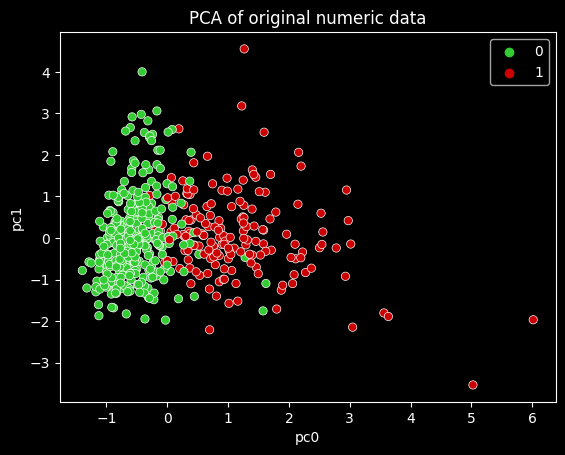

In [32]:
# 8.1 PCA from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA of original numeric data');


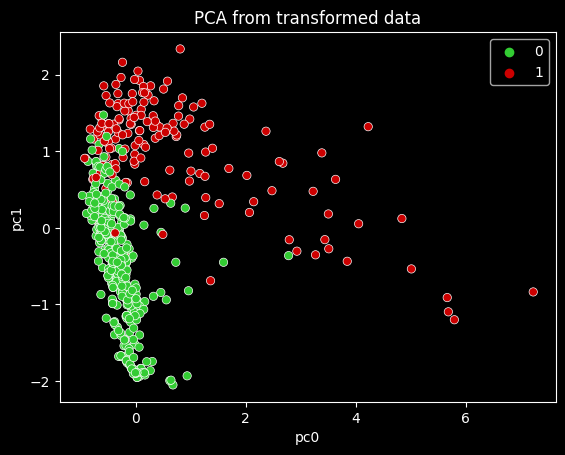

In [33]:
# 8.2 PCA from transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA from transformed data') ;

## xgboost modeling:

In [34]:
# 9.0 Original train/test data:

evals_result= {}
model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,      
                               max_depth = 6,
                               subsample = 0.8, 
                               evals_result = evals_result,
                               random_state = 70,
                              )


tr_X =   orig_train[best_features] 
test_X = orig_test[best_features]  
ytr = ytr 
yte = yte 


model_orig.fit(tr_X, ytr.values,             
               early_stopping_rounds = 50,   
               eval_set=[ (test_X, yte.values)],
               eval_metric = ['auc']        
              )



[11:19:35] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[11:19:35] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[11:19:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-auc:0.94444
[11:19:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.97778
[11:19:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation_0-auc:0.98687
[11:19:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[3]	validation_0-auc:0.98788
[11:19:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.98788
[11:19:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[5]	validation_0-auc:0.98788

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [35]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 0.9939393939393939'

'Best iteration from orig train/test data: 38'

In [36]:
# 9.2 Modeling with transformed train/test data:

evals_result= {}
model_trans = xgb.XGBClassifier( n_estimators= 80,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 6,
                           subsample = 0.8,        
                           evals_result = evals_result,
                           random_state = 70,
                           )


tr_X =   train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr 
yte = yte 


model_trans.fit(tr_X, ytr.values,     
          early_stopping_rounds = 50, 
          eval_set=[ (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[11:19:46] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[11:19:46] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[11:19:46] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-auc:0.90707
[11:19:46] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.95556
[11:19:46] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.95152
[11:19:46] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.95758
[11:19:46] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.97273
[11:19:47] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[5]	validation_0-auc:0.97677

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None, ...)

In [37]:
# 9.3

f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.9949494949494949'

'Best iteration from transformed train/test data: 19'

## Distribution of columns
Distribution of columns related to different centrality measures

In [92]:
def featureImptByCentFeatCounts(colList, normalize = False):
    """
    Desc
    ----
    In the colList, how many columns pertain to
    degree centrality, eigenvector centrality,
    page-rank and clustering coeff. Plot
    by using plotSeries().

    Parameters
    ----------
    colList : A list of columns
    normalize: Boolean

    Returns
    -------
    d : A sorted pandas Series

    """
    d = {'degree' : 0, 'pagerank' : 0, 'eigenvector' : 0, 'clusteringcoeff' : 0,
         "betweenness" : 0, 'avgembeddedness' : 0, 'leidencomsdensity' : 0}
    deg = [i for i in colList if 'deg_' in i ]
    d['degree'] = len(deg)
    pr =  [i for i in colList if 'pr_' in i ]
    d['pagerank'] = len(pr)       
    eig = [i for i in colList if 'eig_' in i ] 
    d['eigenvector'] = len(eig)      
    clu = [i for i in colList if 'clu_' in i ]
    d['clusteringcoeff'] = len(clu)
    bet = [i for i in colList if 'bet_' in i ]
    d['betweenness'] = len(bet)
    ae = [i for i in colList if 'ae_' in i ]
    d['avgembeddedness'] = len(ae)
    den = [i for i in colList if 'den_' in i ]
    d['leidencomsdensity'] = len(den)
    # Transform d to pandas Series:
    d = pd.Series(d).sort_values(ascending = False)
    if (normalize):
        d = d/sum(d)
    return d

In [125]:

def featureImptByScore(score, colList, normalize = False):
    """
    Desc
    ----
    In the colList, total score of columns
    that pertain to degree centrality, to eigenvector
    centrality, to page-rank and clustering coeff and 
    others. Plot by using plotSeries().

    Parameters
    ----------
    score: Pandas Series giving column wise impt score
    colList : A list of dataframe columns
    normalize: Boolean

    Returns
    -------
    d : A sorted pandas Series

    """
    d = {'degree' : 0, 'pagerank' : 0, 'eigenvector' : 0, 'clusteringcoeff' : 0,
         "betweenness" : 0, 'avgembeddedness' : 0, 'leidencomsdensity' : 0}
    deg = [i for i in colList if 'deg_' in i ]
    d['degree'] = score[deg].sum()
    pr =  [i for i in colList if 'pr_' in i ]
    d['pagerank'] = score[pr].sum()      
    eig = [i for i in colList if 'eig_' in i ] 
    d['eigenvector'] = score[eig].sum()    
    clu = [i for i in colList if 'clu_' in i ]
    d['clusteringcoeff'] = score[clu].sum()
    bet = [i for i in colList if 'bet_' in i ]
    d['betweenness'] = score[bet].sum()
    ae = [i for i in colList if 'ae_' in i ]
    d['avgembeddedness'] = score[ae].sum()
    den = [i for i in colList if 'den_' in i ]
    d['leidencomsdensity'] = score[den].sum()
    # Transform d to pandas Series:
    d = pd.Series(d).sort_values(ascending = False)
    if (normalize):
        d = d/sum(d)
    return d
       

In [55]:
colList = (train_trans.iloc[:,len(cat_cols):]).columns
f = featureImptByCentrality(colList, True)

In [56]:
f

eigenvector          0.259259
degree               0.185185
pagerank             0.185185
clusteringcoeff      0.185185
betweenness          0.185185
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

In [49]:
fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 160'

'Columns whose impt is 0: 110'

In [59]:
t = featureImptByCentrality(fe_1, True)
t

eigenvector          0.3125
clusteringcoeff      0.2000
degree               0.1875
pagerank             0.1750
betweenness          0.1250
avgembeddedness      0.0000
leidencomsdensity    0.0000
dtype: float64

In [114]:
def plotSeries(scores, title = ""):
    """
    Desc
    ----
    Plots MI scores or feature impt by centrality 
    calculated by calMIScores() or by featureImptByCentrality()
    Use it as:
        plt.figure(dpi=100, figsize=(8, 5))
        plotSeries(calMIScores(X, y), someTitle)
        OR, as
        plotSeries(featureImptByCentrality, someTitle)
        
    Parameters
    ----------
    scores: Pandas Series    
    
    """
    # Scores sorted in ascending order:
    scores = scores.sort_values(ascending=True)
    # Map parameters:
    width = np.arange(len(scores))
    # Write ticks as per scores index:
    ticks = list(scores.index)
    # Plot width:
    plt.barh(width, scores)
    # Plot yticks
    plt.yticks(width, ticks)
    plt.title(title)

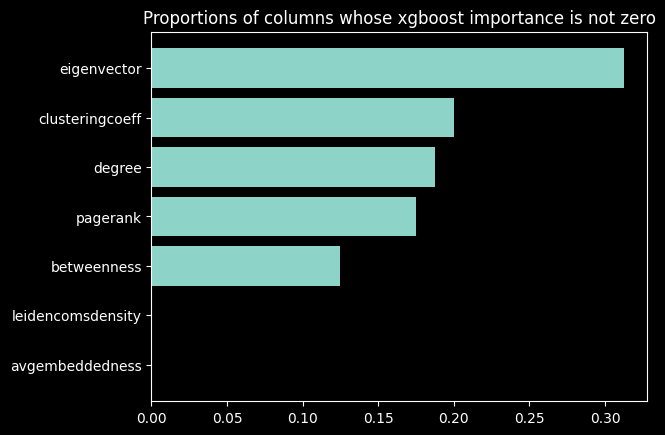

In [65]:
plotSeries(t, "Proportions of columns whose xgboost importance is not zero")

In [95]:
def xgImptFeatures(model, df_columns, filename = None, master=None):
    """
    Given an xgboost classifier model & data col
    names, the function returns two lists of cols,
    one of impt features and the other of 
    unimportant features. Feature importances
    areby 'gain' as against default 'weight'
    in plot_importance() function of xgboost.
   
    Parameters
    ----------
    model: xgboostclassifier model trained on dataframe df
    df_columns: Column names of df. Sequence
                is important: df_columns = list(df.columns)
    master: Folder where impt feature sequence is saved
            File name: fe_1.txt          
    Returns
    -------
    fe_1 : List of columns having features imp > 0 in descending order
    fe_0 : List of columns having features imp of 0.0
    """
    # Sorted index are in descending order of impt
    sorted_idx = model.feature_importances_.argsort()[::-1]
    fe = pd.DataFrame(
                       model.feature_importances_[sorted_idx],
                       index = df_columns[sorted_idx],
                       columns =['imp']
                     )
    # Columns with zero feature impt
    fe_0 = list(fe.loc[fe['imp'] == 0.0, :].index)
    # Columns greater than than zero feature impt
    # fe_1 is in descending order
    fe_1 = list(fe.loc[fe['imp'] > 0.0, :].index)
    print("Order of feature importance is by 'gain'")
    # Save to file
    if filename is not None:
        # Also save these features
        filename = pathlib.Path(master) / filename
        with open(filename,'w') as tfile:
            tfile.write('\n'.join(fe_1))
    return fe_1, fe_0, fe
   

In [96]:
fe_1, fe_0, fe = xgImptFeatures(model_trans, colList)

Order of feature importance is by 'gain'


In [116]:
d = featureImptByCentFeatCounts(colList)

d

eigenvector          70
degree               50
pagerank             50
clusteringcoeff      50
betweenness          50
avgembeddedness       0
leidencomsdensity     0
dtype: int64

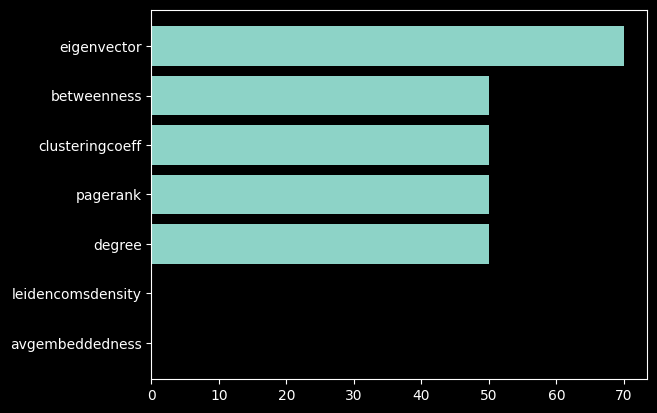

In [115]:
plotSeries(d)

In [122]:
score = fe['imp']

In [124]:
score

deg_area_se_ck_texture_mean                      0.102290
deg_concavity_mean_ck_concavity_worst            0.055836
eig_concavity_mean_ck_texture_mean               0.052912
deg_concavity_worst_ck_area_se_p_texture_mean    0.035450
clu_area_mean_ck_area_se                         0.029509
                                                   ...   
deg_texture_mean_ck_concavity_worst              0.000000
bet_area_se_ck_area_mean_p_concavity_worst       0.000000
deg_area_se_ck_texture_mean_p_concavity_worst    0.000000
eig_area_se_ck_texture_mean_p_concavity_worst    0.000000
deg_area_se_ck_area_mean_p_texture_mean          0.000000
Name: imp, Length: 270, dtype: float32

In [126]:

g = featureImptByScore(score, colList, True)

In [127]:
g.sum()

1.0000001

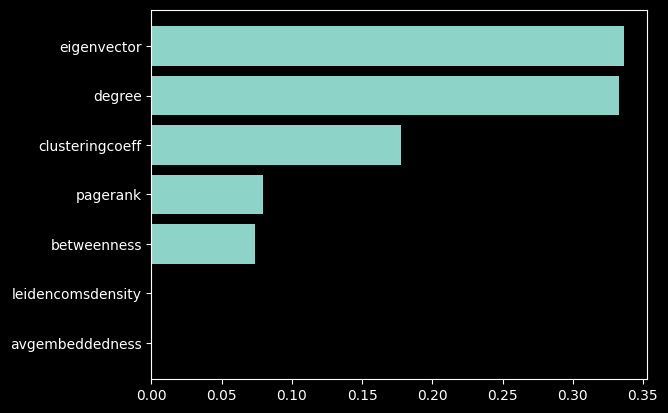

In [128]:
plotSeries(g)

## Mutual information

In [130]:
from sklearn.feature_selection import mutual_info_classif
def calMIScores(X, y):
    """
    Desc
    ---- 
    Calculates mutual information scores when target
    is discrete.

    Parameters
    ----------
    X : Pandas DataFrame 
    y : An array or Series; target

    Returns
    -------
    mi_scores : Pandas Series (sorted)

    """
    
    # Get sores
    mi_scores = mutual_info_classif(X, y)
    # Transform mi_scores to a Series:
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    # Sort Series in Descending order:
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


In [ ]:
def plot_mi_scores(scores):
    # Scores sorted in ascending order:
    scores = scores.sort_values(ascending=True)
    # Map parameters:
    width = np.arange(len(scores))
    # Write ticks as per scores index:
    ticks = list(scores.index)
    # Plot width:
    plt.barh(width, scores)
    # Plot yticks
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [131]:
mi_scores = calMIScores(train_trans[colList], ytr)
mi_scores[::3]  # show a few features with their MI scores

pr_area_mean_ck_area_se_p_texture_mean                  0.414929
eig_area_mean_ck_texture_mean_p_concavity_worst         0.402752
eig_area_mean_ck_area_se_p_concavity_mean               0.391112
eig_area_mean_ck_area_se_p_texture_mean                 0.386659
eig_area_mean_ck_area_se_p_concavity_worst              0.375583
                                                          ...   
deg_texture_mean_ck_concavity_worst_p_concavity_mean    0.056114
eig_area_se_ck_concavity_worst                          0.053810
bet_texture_mean_ck_concavity_worst_p_concavity_mean    0.044329
deg_texture_mean_ck_area_se_p_concavity_worst           0.024046
clu_texture_mean_ck_area_se                             0.013526
Name: MI Scores, Length: 90, dtype: float64

In [142]:
fe.cumsum()
len(fe)

,imp
deg_area_se_ck_texture_mean,0.102290
deg_concavity_mean_ck_concavity_worst,0.158126
eig_concavity_mean_ck_texture_mean,0.211038
deg_concavity_worst_ck_area_se_p_texture_mean,0.246489
clu_area_mean_ck_area_se,0.275997
...,...
deg_texture_mean_ck_concavity_worst,1.000000
bet_area_se_ck_area_mean_p_concavity_worst,1.000000
deg_area_se_ck_texture_mean_p_concavity_worst,1.000000
eig_area_se_ck_texture_mean_p_concavity_worst,1.000000


270

In [145]:
fe['imp'].cumsum().values

array([0.10228997, 0.15812609, 0.21103826, 0.24648869, 0.2759975 ,
       0.30274117, 0.31966263, 0.3360622 , 0.3517667 , 0.36684176,
       0.38087174, 0.3946434 , 0.40809268, 0.4213696 , 0.43438256,
       0.44652382, 0.45809907, 0.4685271 , 0.47778806, 0.48692262,
       0.49593902, 0.50485045, 0.5137514 , 0.52185243, 0.52956975,
       0.537259  , 0.5448478 , 0.55241776, 0.55988777, 0.5672369 ,
       0.5745784 , 0.58190084, 0.5887114 , 0.5954286 , 0.601944  ,
       0.6084577 , 0.61488354, 0.6212507 , 0.62749517, 0.6335446 ,
       0.63957936, 0.645371  , 0.65116125, 0.6569426 , 0.66262543,
       0.6682411 , 0.67381036, 0.6792829 , 0.6847383 , 0.6901152 ,
       0.6954433 , 0.7006943 , 0.7059143 , 0.711041  , 0.71603006,
       0.72095865, 0.7258661 , 0.73071206, 0.7355286 , 0.7403112 ,
       0.7450672 , 0.7497945 , 0.75451154, 0.7590453 , 0.7635721 ,
       0.7680968 , 0.7726133 , 0.77705353, 0.78143615, 0.7858184 ,
       0.7900788 , 0.79430294, 0.7985117 , 0.80270463, 0.80664

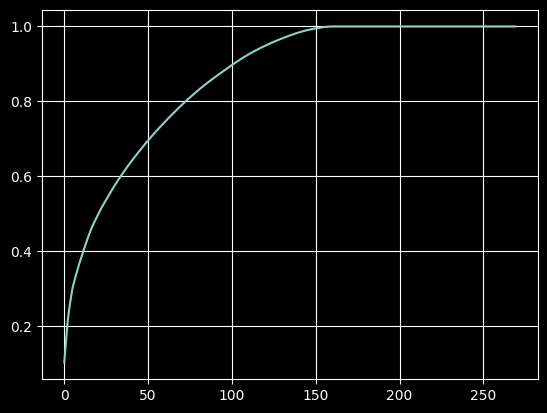

In [148]:
plt.plot(range(len(fe)), fe['imp'].cumsum().values)
plt.grid()

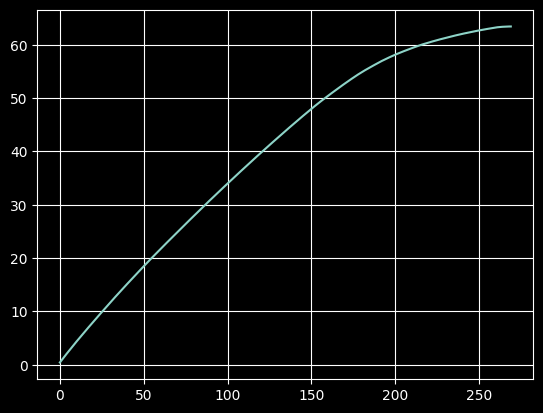

In [149]:
plt.plot(range(len(mi_scores)), mi_scores.cumsum().values)
plt.grid()

<Axes: xlabel='MI Scores', ylabel='Count'>

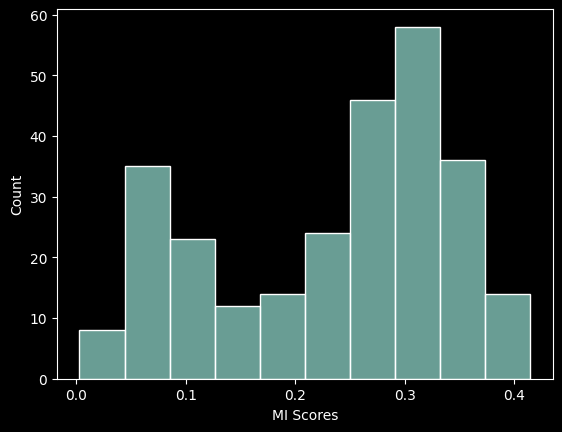

In [133]:
sns.histplot(mi_scores)

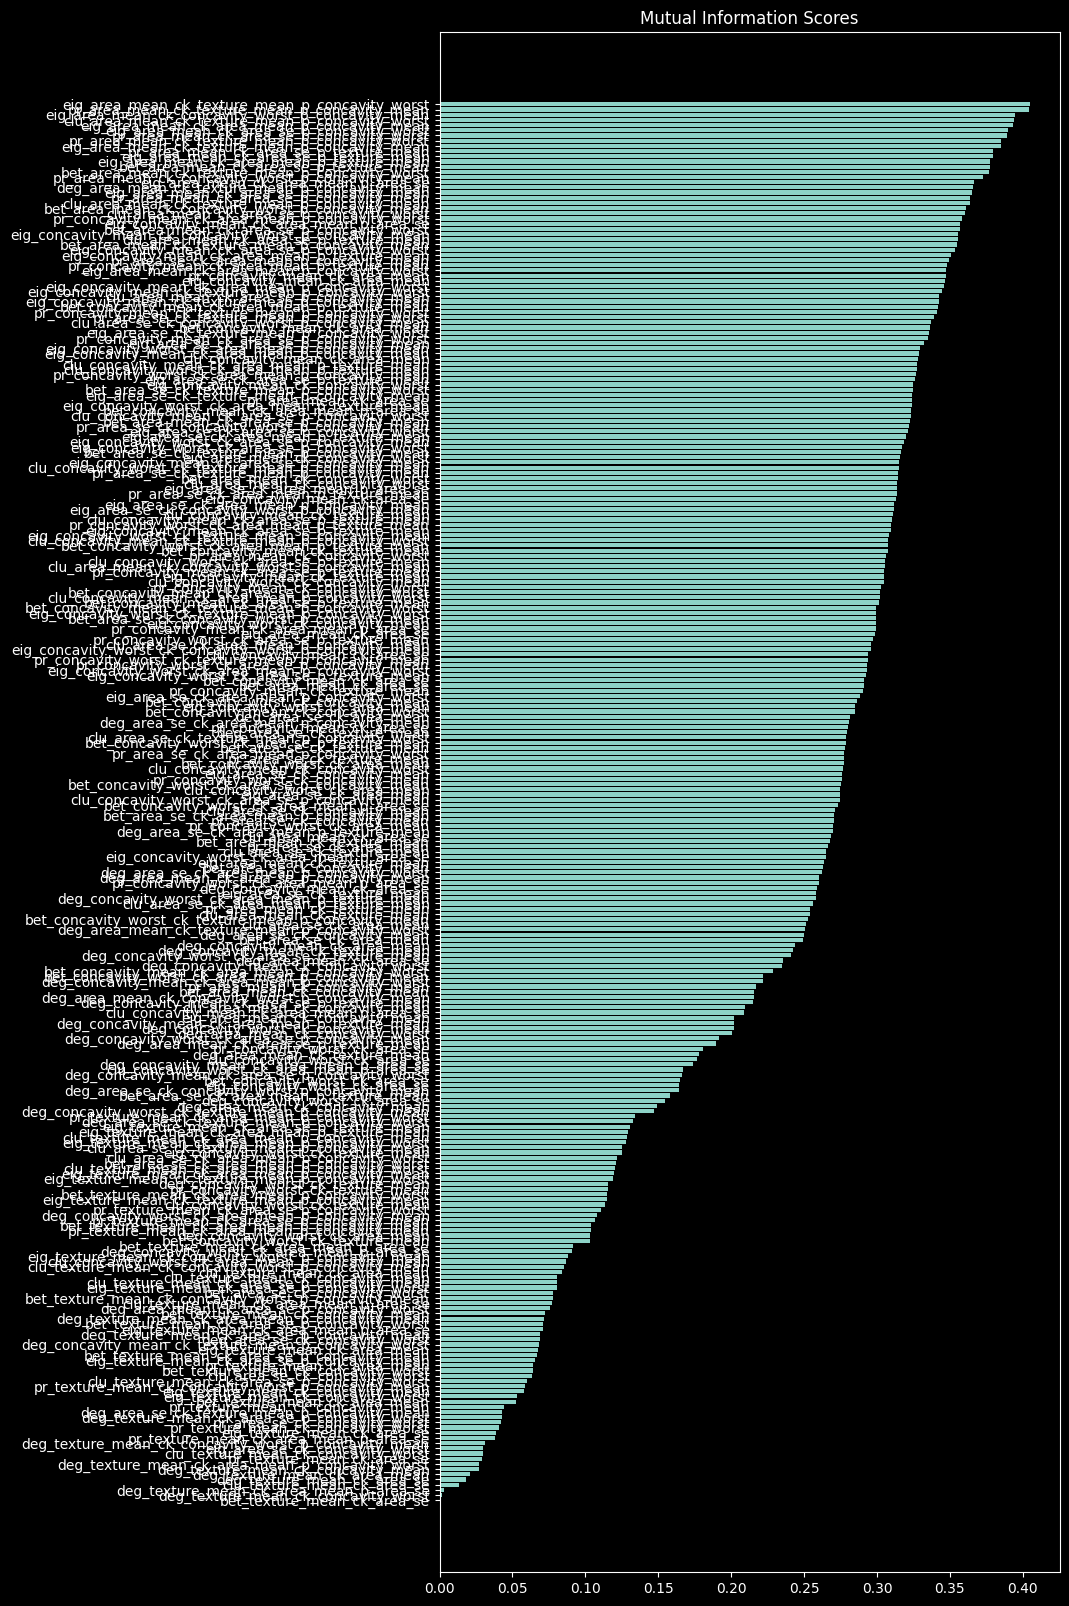

In [ ]:
# 7.1
plt.figure(dpi=100, figsize=(8, 20))
plot_mi_scores(mi_scores);